# ASFP Hydroponics IoT EDA

This notebook performs exploratory data analysis (EDA) on the ASFP hydroponics IoT dataset.

## Goals
- Load and sanity-check the dataset
- Parse timestamps correctly (UTC-aware)
- Clean sensor artifacts (e.g., placeholder zeros)
- Detect outages / irregular sampling and create **segments**
- Fill **short** sensor dropouts without leaking across long outages
- Visualize distributions and time-series behavior **per sensor**
- Create a simple 5‑minute resampled dataset (optional)
- Compute correlations overall and per sensor
- Add light feature engineering (time features + rolling means) for downstream modeling



In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Plotting helpers for dates
import matplotlib.dates as mdates

# Make plots a bit wider in notebooks
plt.rcParams["figure.figsize"] = (10, 4)


## 1) Load data


**Dataset file in this workspace:** `Iot Data.csv`


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Iot Data.csv to Iot Data.csv


In [3]:

# Load the dataset
DATA_PATH = "Iot Data.csv"
df = pd.read_csv(DATA_PATH)


df.head()


,TIME,Sensors,Water Temperature,pH,EC,DO
0,2022-08-10T02:02:56.000Z,1,26.1,8.3,0.66,5.1
1,2022-08-10T02:05:10.000Z,2,23.9,8.6,0.65,5.0
2,2022-08-10T02:07:59.000Z,1,25.9,8.3,0.67,5.2
3,2022-08-10T02:12:18.000Z,2,23.9,8.6,0.65,4.9
4,2022-08-10T02:13:01.000Z,1,25.7,8.3,0.67,5.1


## 2) Quick structure & missingness checks

These checks tell :
- what columns exist and their dtypes
- whether there are obvious missing values
- whether any columns that should be numeric are actually strings


In [4]:
print("Shape:", df.shape)
display(df.head(3))
display(df.tail(3))

print("\nDtypes:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())


Shape: (32319, 6)


,TIME,Sensors,Water Temperature,pH,EC,DO
0,2022-08-10T02:02:56.000Z,1,26.1,8.3,0.66,5.1
1,2022-08-10T02:05:10.000Z,2,23.9,8.6,0.65,5.0
2,2022-08-10T02:07:59.000Z,1,25.9,8.3,0.67,5.2


,TIME,Sensors,Water Temperature,pH,EC,DO
32316,2022-11-30T14:46:12.000Z,1,18.1,5.6,2.96,5.3
32317,2022-11-30T14:58:55.000Z,1,18.0,5.6,2.96,5.2
32318,2022-11-30T14:58:56.000Z,2,18.1,5.7,2.79,0.1



Dtypes:
TIME                  object
Sensors                int64
Water Temperature    float64
pH                   float64
EC                   float64
DO                   float64
dtype: object

Missing values per column:
TIME                 0
Sensors              0
Water Temperature    0
pH                   0
EC                   0
DO                   0
dtype: int64


## 3) Standardize column names and parse time

We convert the timestamp column to a timezone-aware `datetime64[ns, UTC]`

Why UTC?
- Avoids daylight-saving time issues.
- Makes multi-sensor alignment consistent.


In [12]:


df = df.copy()

# Strip whitespace in headers
df.columns = [c.strip() for c in df.columns]


rename_map = {
    "time": "time",
    "TIME": "time",
    "Time": "time",
    "Timestamp": "time",
    "Sensors": "sensor",
    "Sensor": "sensor",
    "Water Temperature": "water_temp",
    "WaterTemperature": "water_temp",
    "ph": "ph",
    "pH": "ph",
    "ec": "ec",
    "EC": "ec",
    "do": "do",
    "DO": "do"
}

df = df.rename(columns=rename_map)
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

# Parse time
df["time"] = pd.to_datetime(df["time"], errors="coerce", utc=True)

# Drop rows with bad timestamps (can't use them in time-series work)
before = len(df)
df = df.dropna(subset=["time"])
after = len(df)
print(f"Dropped {before-after} rows with invalid timestamps.")
# all dates converted succesfully


Dropped 0 rows with invalid timestamps.


## 4) Coerce sensor columns to numeric

IoT CSVs often store numeric columns as strings.  
We convert to numeric and coerce errors to NaN so they can be handled explicitly.


In [8]:
print(df.columns.tolist())


['time', 'sensor', 'water_temp', 'pH', 'EC', 'DO']


In [13]:
# Force numeric for sensor measurements
num_cols = ["water_temp", "ph", "ec", "do"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print("Missing after numeric coercion:")
print(df[num_cols].isna().sum())


Missing after numeric coercion:
water_temp    0
ph            0
ec            0
do            0
dtype: int64


## 5) Sort properly and compute time deltas per sensor

Sorting is **required** before computing time differences.  
`dt_seconds` is the gap (seconds) between consecutive readings within the same sensor stream.


In [14]:
df = df.sort_values(["sensor", "time"]).reset_index(drop=True)

# time step between consecutive readings within each sensor stream
df["dt_seconds"] = df.groupby("sensor")["time"].diff().dt.total_seconds() #.dt.total_seconds() converts time diff into seconds

df[["sensor", "time", "dt_seconds"]].head(10)


,sensor,time,dt_seconds
0,1,2022-08-10 02:02:56+00:00,NaN
1,1,2022-08-10 02:07:59+00:00,303.0
2,1,2022-08-10 02:13:01+00:00,302.0
3,1,2022-08-10 02:18:03+00:00,302.0
4,1,2022-08-10 02:23:05+00:00,302.0
5,1,2022-08-10 02:28:08+00:00,303.0
6,1,2022-08-10 02:33:10+00:00,302.0
7,1,2022-08-10 02:38:13+00:00,303.0
8,1,2022-08-10 02:43:15+00:00,302.0
9,1,2022-08-10 02:48:17+00:00,302.0


We can observe that the sensor is taking reading rougly every 300 seconds (5 min)

## 6) Create 'segment' IDs to avoid leakage across outages

We increment `segment` whenever there's a "big gap".  
Here we define a big gap as > 10 minutes (600s)

This lets us:
- avoid forward-fill across outages
- compute rolling features only within continuous periods
- plot without fake diagonal ramps


In [15]:
# "segment" increments whenever there's a big gap
GAP_BREAK_SECONDS = 600  # 10 minutes (2× a 5-min expected interval)

df["segment"] = (df["dt_seconds"] > GAP_BREAK_SECONDS).groupby(df["sensor"]).cumsum()

df[["sensor", "time", "dt_seconds", "segment"]].head(10)


,sensor,time,dt_seconds,segment
0,1,2022-08-10 02:02:56+00:00,NaN,0
1,1,2022-08-10 02:07:59+00:00,303.0,0
2,1,2022-08-10 02:13:01+00:00,302.0,0
3,1,2022-08-10 02:18:03+00:00,302.0,0
4,1,2022-08-10 02:23:05+00:00,302.0,0
5,1,2022-08-10 02:28:08+00:00,303.0,0
6,1,2022-08-10 02:33:10+00:00,302.0,0
7,1,2022-08-10 02:38:13+00:00,303.0,0
8,1,2022-08-10 02:43:15+00:00,302.0,0
9,1,2022-08-10 02:48:17+00:00,302.0,0


Zeros here because there havent been any outages (gaps over 10 min) yet.

## 7) Inspect large outages (e.g., > 1 hour)

This is diagnostic: it tells you how often the data stream goes missing for long periods.  
Each row shown is the **first reading after** the outage.


In [16]:
# Inspect big gaps (> 1 hour)
gaps = df[df["dt_seconds"] > 3600][["sensor", "time", "dt_seconds", "segment"]]
print("Big gaps:", len(gaps))
display(gaps.head(10))

big = df.loc[df["dt_seconds"] > 3600, "dt_seconds"]

summary = pd.DataFrame({
    "gap_hours": (big / 3600).describe(),
    "gap_days":  (big / 86400).describe(),
}).round(3)

display(summary)


Big gaps: 55


,sensor,time,dt_seconds,segment
12249,1,2022-09-28 10:44:58+00:00,556324.0,12
12394,1,2022-11-04 18:20:00+00:00,3194627.0,13
14884,1,2022-11-15 23:34:21+00:00,15950.0,283
14910,1,2022-11-16 20:21:13+00:00,58108.0,292
14913,1,2022-11-16 23:11:01+00:00,6238.0,295
14939,1,2022-11-17 11:59:32+00:00,19722.0,308
14940,1,2022-11-17 13:29:58+00:00,5426.0,309
14944,1,2022-11-17 22:06:03+00:00,26007.0,313
14945,1,2022-11-17 23:27:46+00:00,4903.0,314
14957,1,2022-11-18 03:36:34+00:00,5560.0,322


,gap_hours,gap_days
count,55.000,55.000
mean,41.790,1.741
std,168.222,7.009
min,1.034,0.043
25%,1.454,0.061
50%,2.375,0.099
75%,5.898,0.246
max,887.396,36.975


We have a 36 day gap in between sensor readings...

## 8) Treat placeholder zeros as missing (NaN)

For hydroponics water-quality sensors, exact zeros in pH/EC/DO are commonly placeholders
for sensor dropouts or invalid measurements.

- pH = 0 is physically implausible here
- EC = 0 implies ion-free water (inconsistent with nutrient solution)
- DO = 0 could happen in rare conditions, but exact 0 frequently indicates a sensor issue

We replace these with NaN so downstream steps handle them as missing.


In [17]:
df = df.copy()

for col in ["ph", "ec", "do"]:
    df.loc[df[col] == 0, col] = np.nan

print("Zeros converted to NaN; remaining missingness:")
print(df[["ph","ec","do"]].isna().sum())


Zeros converted to NaN; remaining missingness:
ph    668
ec     50
do    551
dtype: int64


## 9) Fill short dropouts only (segment-aware forward-fill)

Forward-fill is reasonable for brief sensor dropouts **within a continuous segment**.
But it should not bridge long outages.

We fill within `(sensor, segment)` and cap the number of filled rows with `limit`.

**Important nuance:** `limit` is in **rows**, not time.  
If sampling is ~5 minutes, `limit=12` ≈ 1 hour.


In [18]:
cols = ["water_temp", "ph", "ec", "do"]

FILL_LIMIT_ROWS = 12  # ≈ 1 hour if sampling is 5 minutes

df[cols] = (
    df.groupby(["sensor", "segment"])[cols]
      .ffill(limit=FILL_LIMIT_ROWS)
)

print("Remaining NaNs after segment-limited fill:")
print(df[cols].isna().sum())


Remaining NaNs after segment-limited fill:
water_temp      0
ph            577
ec             18
do            280
dtype: int64


## 10) Descriptive stats by sensor

This helps you identify sensor-to-sensor differences that can create pooled bimodal histograms.


In [19]:
display(df.groupby("sensor")[cols].describe())


water_temp                                                          ph  \
            count       mean       std   min   25%   50%   75%   max    count   
sensor                                                                          
1         16161.0  20.618402  2.887585  13.6  18.4  19.5  23.0  29.1  15585.0   
2         16158.0  19.730746  2.120888  15.5  18.2  19.1  21.8  25.0  16157.0   

                  ...    ec             do                                     \
            mean  ...   75%   max    count      mean       std  min  25%  50%   
sensor            ...                                                           
1       6.343638  ...  2.67  7.43  16160.0  5.412983  2.861427  0.4  3.5  4.7   
2       6.528650  ...  2.20  3.81  15879.0  1.865640  4.277151  0.1  0.4  0.8   

                   
        75%   max  
sensor             
1       7.0  48.0  
2       2.2  30.0  

[2 rows x 32 columns]

## 11) Histograms

We plot histograms **by sensor** (overlaid) to avoid mixing regimes and misinterpreting bimodality.
Y-axis 'count' = number of readings in each bin.


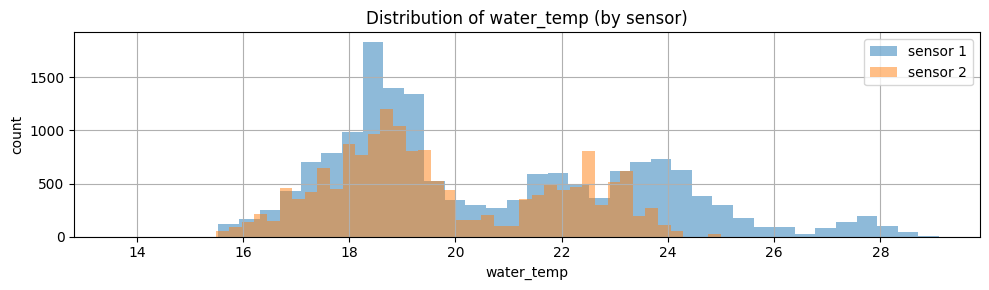

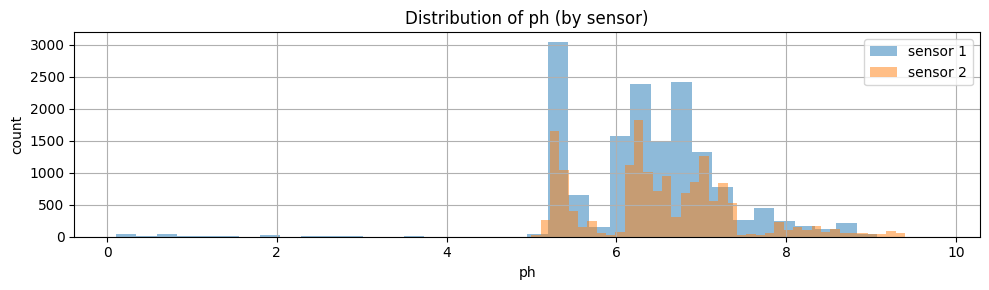

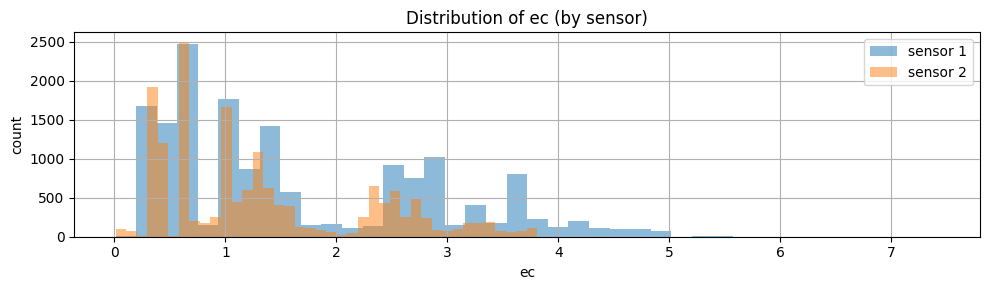

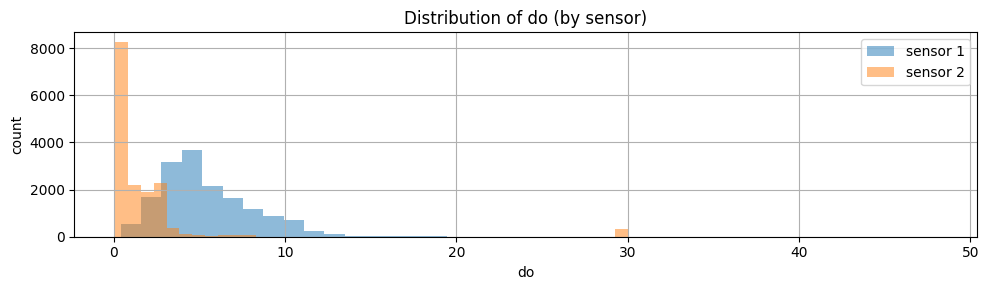

In [20]:
for c in cols:
    plt.figure(figsize=(10,3))
    for sensor_id, g in df.groupby("sensor"):
        g[c].hist(bins=40, alpha=0.5, label=f"sensor {sensor_id}")
    plt.title(f"Distribution of {c} (by sensor)")
    plt.xlabel(c)
    plt.ylabel("count")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 12) Time series plots per sensor (no fake ramps)

Matplotlib connects points by default. If there are outages, it draws misleading diagonal lines.
We break the line at gap boundaries by setting values to NaN when `dt_seconds` exceeds `GAP_BREAK_SECONDS`.


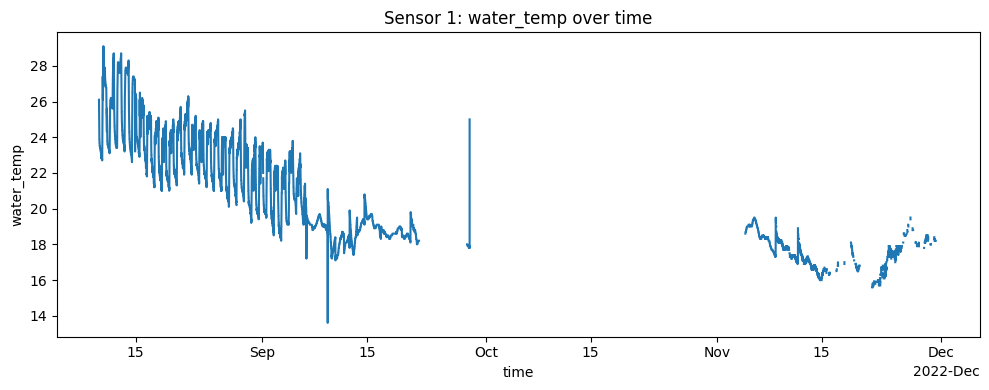

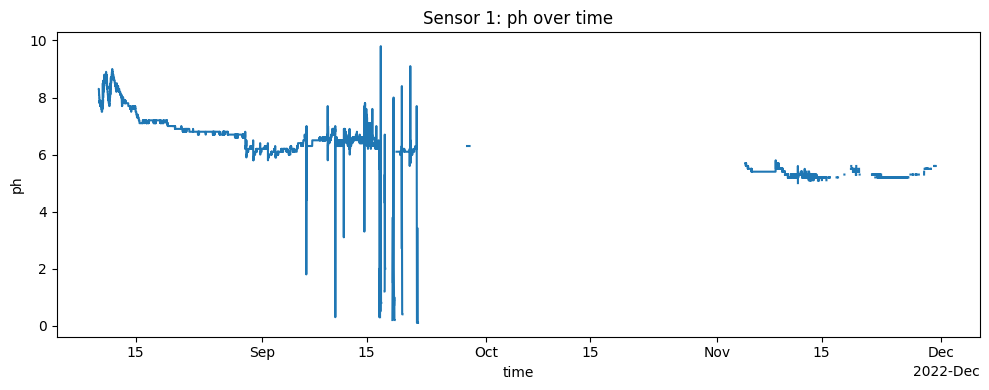

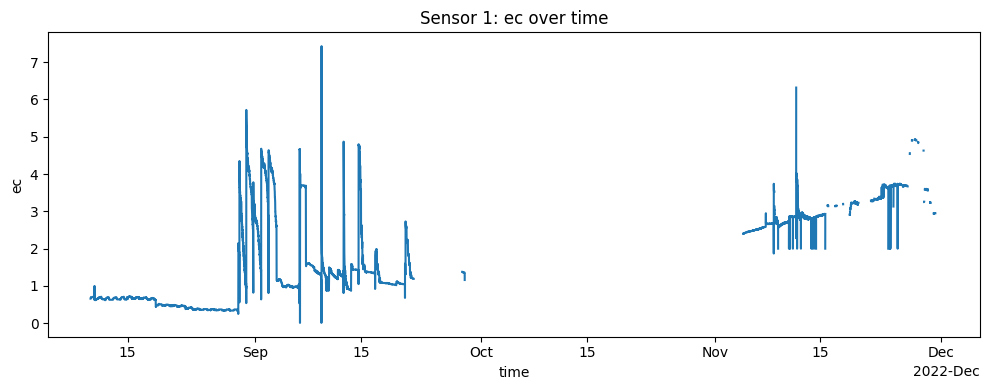

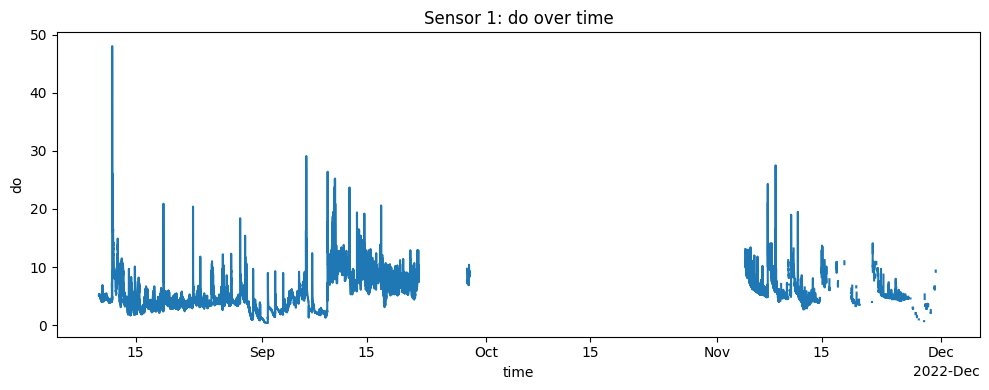

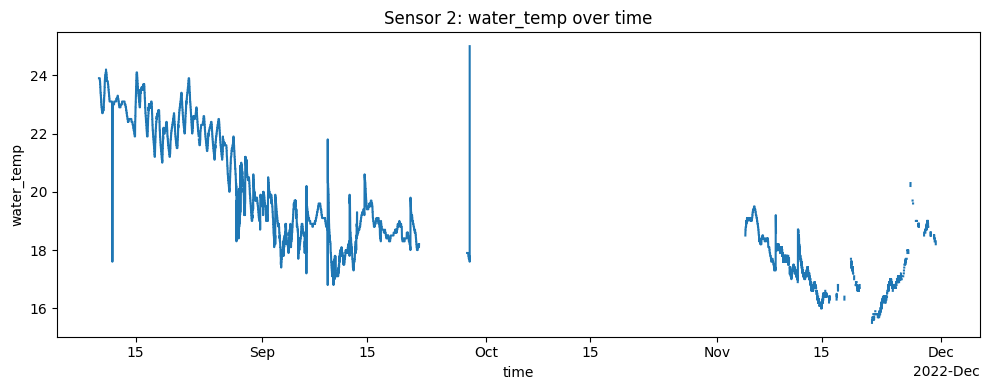

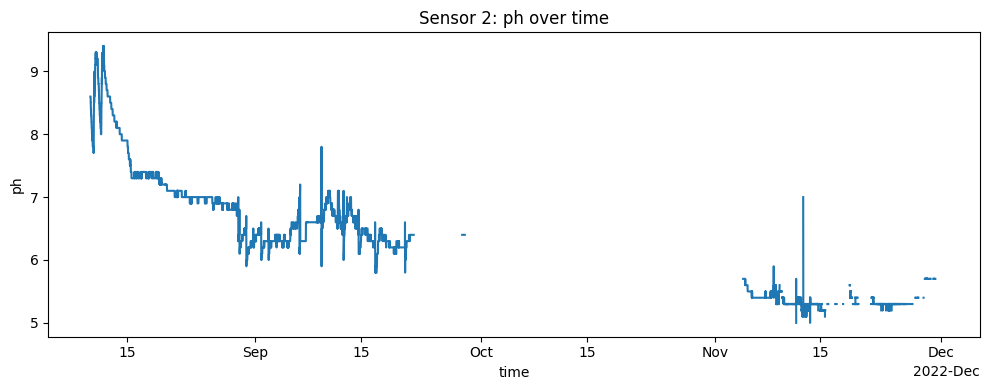

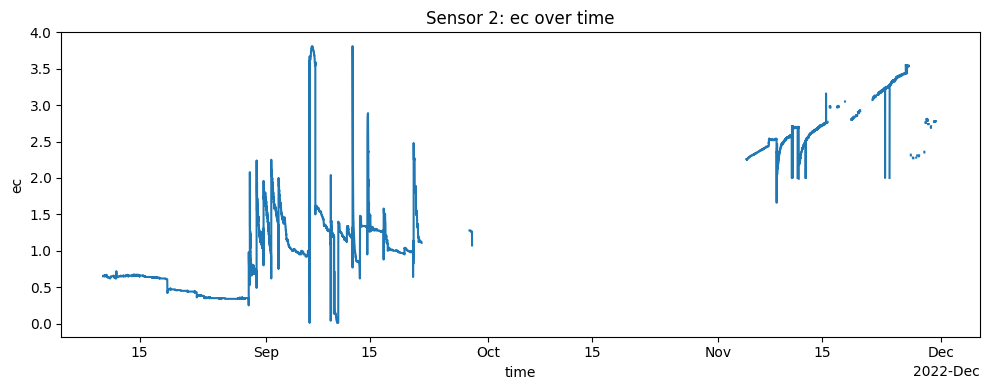

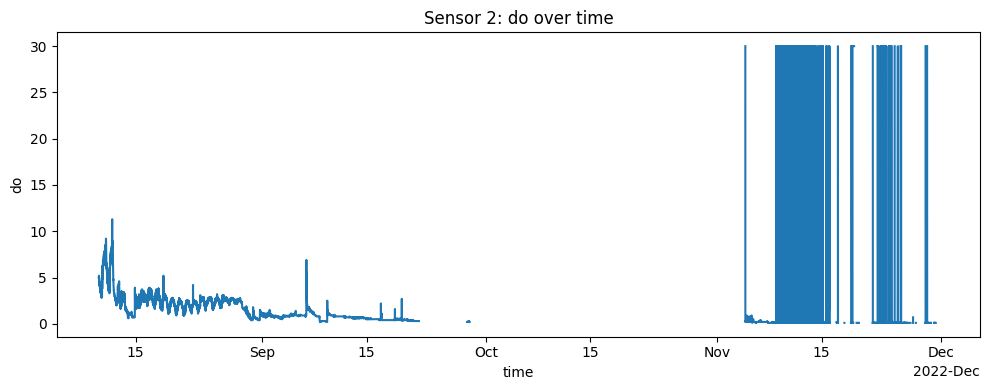

In [21]:
for sensor_id, g in df.groupby("sensor"):
    g = g.sort_values("time").copy()

    for c in cols:
        gg = g[["time", "dt_seconds", c]].copy()
        gg.loc[gg["dt_seconds"] > GAP_BREAK_SECONDS, c] = np.nan  # break across outages

        plt.figure(figsize=(10,4))
        plt.plot(gg["time"], gg[c])
        plt.title(f"Sensor {sensor_id}: {c} over time")
        plt.xlabel("time")
        plt.ylabel(c)

        ax = plt.gca()
        loc = mdates.AutoDateLocator()
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))

        plt.tight_layout()
        plt.show()


The dissolved oxygen time series exhibits extended periods of physically plausible behavior, followed by intervals of extreme saturation values (>30 ppm) and rapid oscillations that exceed known solubility limits. These patterns indicate sensor malfunction or calibration failure rather than true environmental variation

## 14) Correlations

Correlations will give us a first-pass view of relationships (not causation).  
Compute:
- overall correlation matrix
- correlation matrix per sensor


In [22]:
print("Overall correlation (pooled):")
display(df[cols].corr())

print("\nCorrelation by sensor:")
for sensor_id, g in df.groupby("sensor"):
    print(f"Sensor {sensor_id}")
    display(g[cols].corr())


Overall correlation (pooled):


,water_temp,ph,ec,do
water_temp,1.000000,0.705108,-0.574527,-0.019118
ph,0.705108,1.000000,-0.642880,-0.057556
ec,-0.574527,-0.642880,1.000000,0.071747
do,-0.019118,-0.057556,0.071747,1.000000



Correlation by sensor:
Sensor 1


,water_temp,ph,ec,do
water_temp,1.000000,0.695620,-0.568452,-0.295914
ph,0.695620,1.000000,-0.551262,-0.090605
ec,-0.568452,-0.551262,1.000000,-0.026930
do,-0.295914,-0.090605,-0.026930,1.000000


Sensor 2


,water_temp,ph,ec,do
water_temp,1.000000,0.814822,-0.699059,0.063435
ph,0.814822,1.000000,-0.771037,0.047871
ec,-0.699059,-0.771037,1.000000,0.031993
do,0.063435,0.047871,0.031993,1.000000


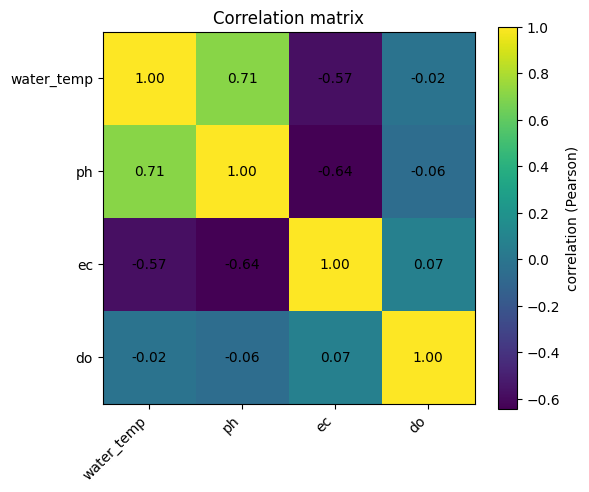

In [23]:
import matplotlib.pyplot as plt
import numpy as np

cols = ["water_temp", "ph", "ec", "do"]
corr = df[cols].corr().values

plt.figure(figsize=(6,5))
plt.imshow(corr)
plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.yticks(range(len(cols)), cols)
plt.colorbar(label="correlation (Pearson)")
plt.title("Correlation matrix")

for i in range(len(cols)):
    for j in range(len(cols)):
        plt.text(j, i, f"{corr[i,j]:.2f}", ha="center", va="center")

plt.tight_layout()
plt.show()


## 15) Simple feature engineering (for downstream modeling)

These features are typical for time-series ML:
- hour/day/month cyclical-ish proxies
- rolling 1-hour mean (computed within sensor+segment)

Note: Rolling features should never cross outages, hence the groupby.


In [24]:
# Time features
df["hour"] = df["time"].dt.hour
df["dayofweek"] = df["time"].dt.dayofweek
df["month"] = df["time"].dt.month

# Rolling window features (1 hour ≈ 12 samples if 5-min cadence)
ROLL_WINDOW = 12

for c in cols:
    df[f"{c}_roll1h_mean"] = (
        df.groupby(["sensor", "segment"])[c]
          .transform(lambda s: s.rolling(ROLL_WINDOW, min_periods=3).mean())
    )

display(df[["sensor","time","segment","hour","dayofweek","month"] + [f"{c}_roll1h_mean" for c in cols]].head(10))


,sensor,time,segment,hour,dayofweek,month,water_temp_roll1h_mean,ph_roll1h_mean,ec_roll1h_mean,do_roll1h_mean
0,1,2022-08-10 02:02:56+00:00,0,2,2,8,NaN,NaN,NaN,NaN
1,1,2022-08-10 02:07:59+00:00,0,2,2,8,NaN,NaN,NaN,NaN
2,1,2022-08-10 02:13:01+00:00,0,2,2,8,25.900000,8.300000,0.666667,5.133333
3,1,2022-08-10 02:18:03+00:00,0,2,2,8,25.750000,8.275000,0.670000,5.175000
4,1,2022-08-10 02:23:05+00:00,0,2,2,8,25.560000,8.260000,0.672000,5.200000
5,1,2022-08-10 02:28:08+00:00,0,2,2,8,25.400000,8.250000,0.673333,5.200000
6,1,2022-08-10 02:33:10+00:00,0,2,2,8,25.285714,8.228571,0.674286,5.200000
7,1,2022-08-10 02:38:13+00:00,0,2,2,8,25.187500,8.212500,0.675000,5.200000
8,1,2022-08-10 02:43:15+00:00,0,2,2,8,25.100000,8.200000,0.676667,5.188889
9,1,2022-08-10 02:48:17+00:00,0,2,2,8,25.030000,8.190000,0.678000,5.180000


## 16)  sanity checks

Making sure:
- no obvious time parsing issues
- segmenting behaved as expected
- remaining NaNs are understood (true missingness after dropouts/outages)


In [25]:
print("Time range:", df["time"].min(), "->", df["time"].max())
print("\nRows per sensor:")
print(df.groupby("sensor").size())

print("\nRemaining NaNs (key cols):")
print(df[cols].isna().sum())

print("\nLargest dt_seconds per sensor (outage magnitude):")
display(df.groupby("sensor")["dt_seconds"].max())


Time range: 2022-08-10 02:02:56+00:00 -> 2022-11-30 14:58:56+00:00

Rows per sensor:
sensor
1    16161
2    16158
dtype: int64

Remaining NaNs (key cols):
water_temp      0
ph            577
ec             18
do            280
dtype: int64

Largest dt_seconds per sensor (outage magnitude):


,dt_seconds
sensor,
1,3194627.0
2,3193709.0


In [27]:
# --- Diagnostic: zero-value prevalence in RAW data (before cleaning) ---
raw = pd.read_csv("Iot Data.csv")
raw.columns = [c.strip() for c in raw.columns]

raw = raw.rename(columns={
    "Sensors": "sensor",
    "Water Temperature": "water_temp",
    "pH": "ph",
    "EC": "ec",
    "DO": "do"
})

zero_pct = (raw[["ph","ec","do"]] == 0).mean().mul(100).round(2)
zero_counts = (raw[["ph","ec","do"]] == 0).sum()

print("Zero counts:")
print(zero_counts)
print("\nZero percentages (%):")
print(zero_pct)


Zero counts:
ph    668
ec     50
do    551
dtype: int64

Zero percentages (%):
ph    2.07
ec    0.15
do    1.70
dtype: float64


In [29]:
#cleaned csv for modeling
df.to_csv("asfp_cleaned_features.csv", index=False)



In [30]:
from google.colab import files

files.download("asfp_cleaned_features.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>